In [1]:
import os
import mlflow
import psycopg
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

TABLE_NAME = "users_churn"

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "churn_fio"
RUN_NAME = "eda"

ASSETS_DIR = "assets"

os.makedirs(ASSETS_DIR, exist_ok=True)

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

sns.set_style("white")
sns.set_theme(style="whitegrid")

In [2]:
from dotenv import load_dotenv
load_dotenv()

connection = {"target_session_attrs": "read-write"}#"sslmode": "verify-full"
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

df.head(2)

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,17,8191-XWSZG,2015-10-01,NaT,One year,No,Mailed check,20.65,1022.95,None,None,None,None,None,None,None,Female,0,No,No,No,0
1,59,3957-SQXML,2017-04-01,NaT,Two year,No,Credit card (automatic),24.95,894.30,None,None,None,None,None,None,None,Female,0,Yes,Yes,Yes,0


## Задача №1

/tmp/ipykernel_5070/1880405480.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 0].set_xticklabels(df[x].unique(), rotation = 45);


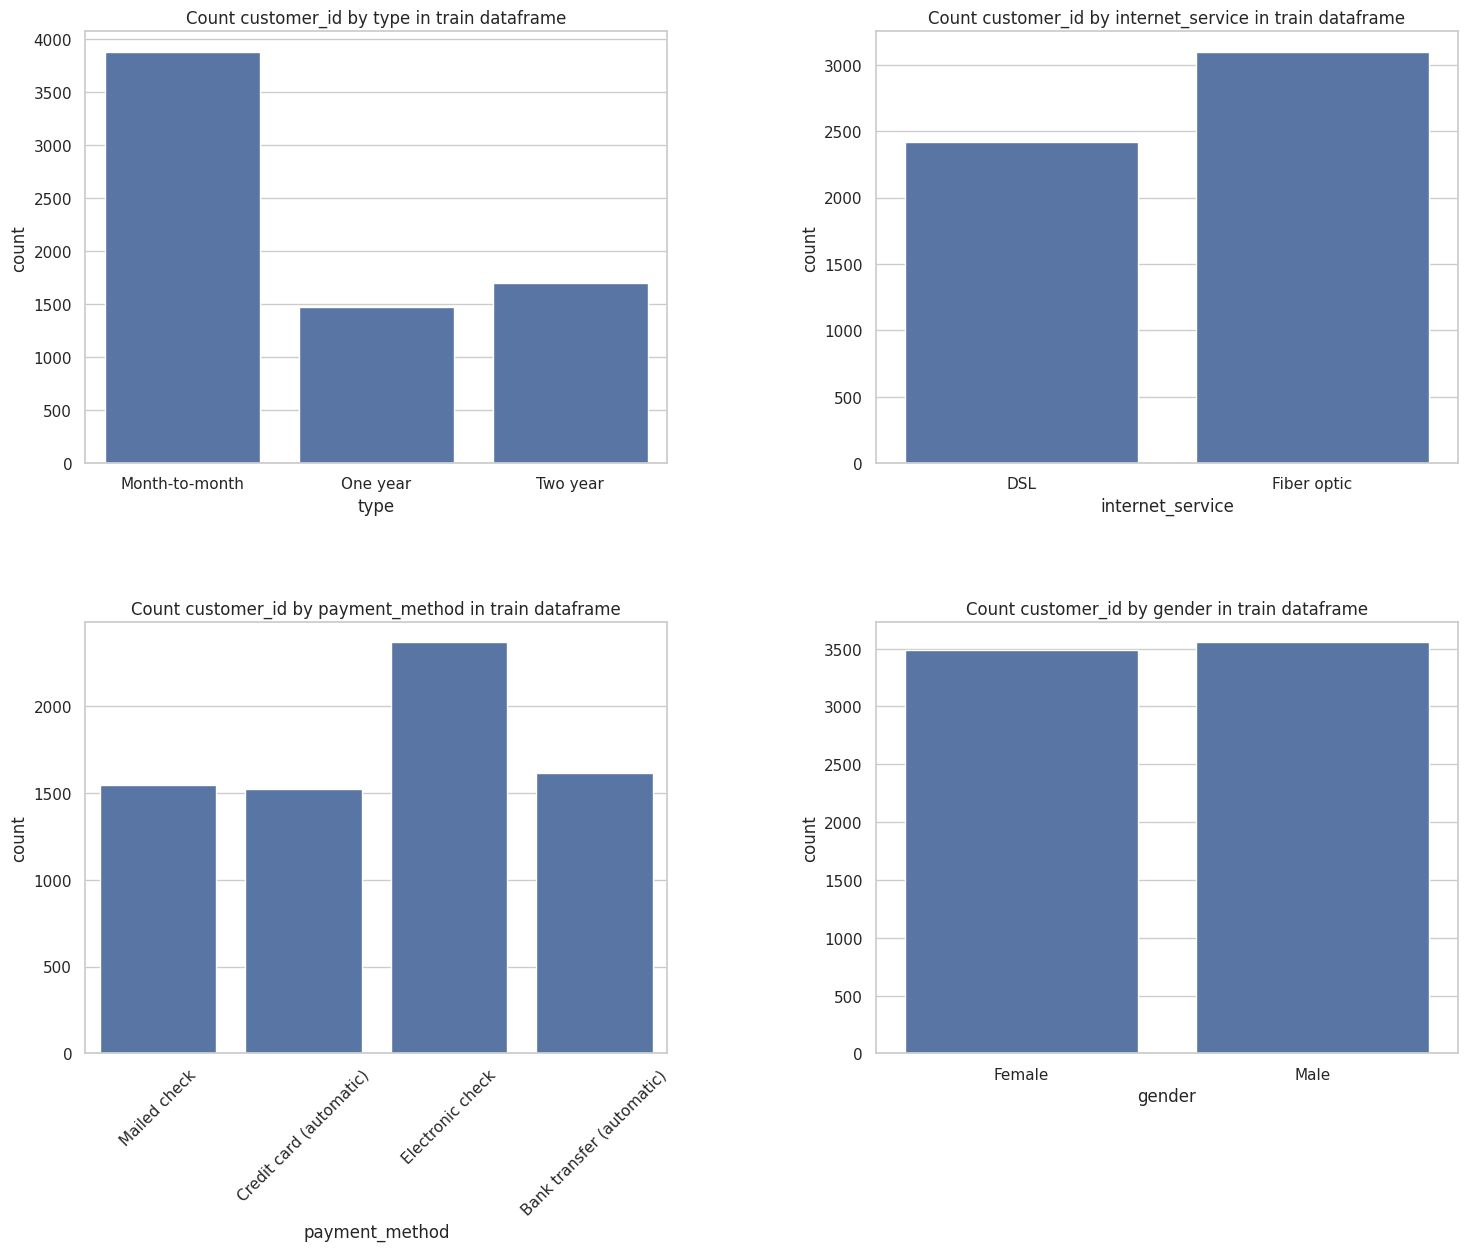

In [3]:
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.6)
fig.set_size_inches(16.5, 12.5, forward=True)


x = "type"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(by=x, as_index=False)[y].agg(stat)
sns.barplot(
    data=agg_df,
    x=x,
    y=stat[0],
    ax=axs[0, 0]
)
axs[0, 0].set_title(f'Count {y} by {x} in train dataframe')

x = "payment_method"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(by=x, as_index=False)[y].agg(stat)
sns.barplot(
    data=agg_df,
    x=x,
    y=stat[0],
    ax=axs[1, 0]
)
axs[1, 0].set_title(f'Count {y} by {x} in train dataframe')
axs[1, 0].set_xticklabels(df[x].unique(), rotation = 45);

x = "internet_service"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(by=x, as_index=False)[y].agg(stat)
sns.barplot(
    data=agg_df,
    x=x,
    y=stat[0],
    ax=axs[0, 1],
)
axs[0, 1].set_title(f'Count {y} by {x} in train dataframe')

x = "gender"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(by=x, as_index=False)[y].agg(stat)
sns.barplot(
    data=agg_df,
    x=x,
    y=stat[0],
    ax=axs[1, 1]
)
axs[1, 1].set_title(f'Count {y} by {x} in train dataframe')

plt.savefig(os.path.join(ASSETS_DIR, "cat_features_1"))

## Задача №2

In [4]:
x = "customer_id"
binary_columns = [
    "online_security", 
    "online_backup", 
    "device_protection", 
    "tech_support",
    "streaming_tv",
    "streaming_movies",
    "senior_citizen",
    "partner",
    "dependents",
]
stat = ['count']

print(df.groupby(binary_columns).agg(stat[0])[x].reset_index().sort_values(by=x, ascending=False).head(10))

    online_security online_backup device_protection tech_support streaming_tv   
0                No            No                No           No           No  \
106              No           Yes                No           No           No   
414             Yes           Yes               Yes          Yes          Yes   
4                No            No                No           No           No   
8                No            No                No           No           No   
15               No            No                No           No          Yes   
214             Yes            No                No           No           No   
22               No            No                No           No          Yes   
413             Yes           Yes               Yes          Yes          Yes   
3                No            No                No           No           No   

    streaming_movies  senior_citizen partner dependents  customer_id  
0                 No               0 

## Задача №3

In [5]:
df[binary_columns] = df[binary_columns].replace({'No': 0, 'Yes':1})

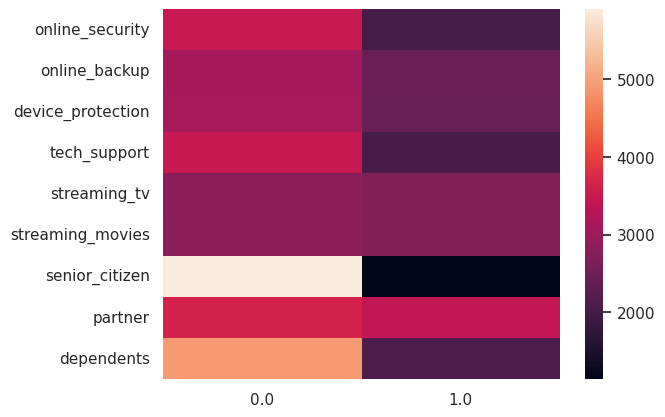

In [6]:
heat_df = df[binary_columns].apply(pd.Series.value_counts).T
sns.heatmap(heat_df)

plt.savefig(os.path.join(ASSETS_DIR, "cat_features_2_binary_heatmap"))

## Задача №4

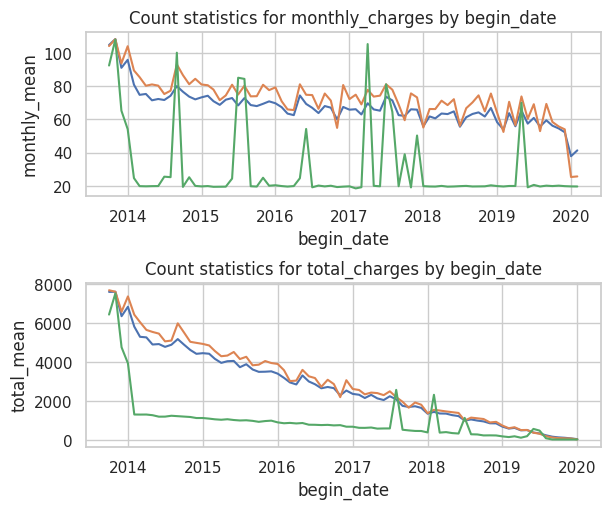

In [7]:
# инициализация переменной для названия колонки
x = "begin_date"

# список колонок, для которых будут вычисляться статистики
charges_columns = [
    "monthly_charges",
    "total_charges",
]

# список статистик, которые будут вычисляться для каждой группы
stats = ["mean", "median", lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else None]  # среднее значение, медиана и мода

# группировка данных по дате начала и агрегация статистик для ежемесячных платежей (используйте reset_index для сброса индекса в таблице)
charges_monthly_agg = df.groupby(x).agg({charges_columns[0]: stats}).reset_index()
# удаление верхнего уровня индекса колонок (после агрегации)
charges_monthly_agg.columns = charges_monthly_agg.columns.droplevel()
# переименование колонок для удобства восприятия
charges_monthly_agg.columns = [x, "monthly_mean", "monthly_median", "monthly_mode"]

# аналогично для общих платежей
charges_total_agg = df.groupby(x).agg({charges_columns[1]: stats}).reset_index()
charges_total_agg.columns = charges_total_agg.columns.droplevel()
charges_total_agg.columns = [x, "total_mean", "total_median", "total_mode"]

# создание объекта для отображения графиков (2 графика вертикально)
fig, axs = plt.subplots(2, 1)
# настройка отступов между графиками
fig.tight_layout(pad=2.5)
# установка размера фигуры
fig.set_size_inches(6.5, 5.5, forward=True)

# построение линейных графиков для ежемесячных платежей
sns.lineplot(charges_monthly_agg, x=x, y="monthly_mean", ax=axs[0])
sns.lineplot(charges_monthly_agg, x=x, y="monthly_median", ax=axs[0])
sns.lineplot(charges_monthly_agg, x=x, y="monthly_mode", ax=axs[0])
# установка заголовка для верхнего графика
axs[0].set_title(f"Count statistics for {charges_columns[0]} by {x}")

# построение линейных графиков для общих платежей
sns.lineplot(charges_total_agg, x=x, y="total_mean", ax=axs[1])
sns.lineplot(charges_total_agg, x=x, y="total_median", ax=axs[1])
sns.lineplot(charges_total_agg, x=x, y="total_mode", ax=axs[1])
# установка заголовка для нижнего графика
axs[1].set_title(f"Count statistics for {charges_columns[1]} by {x}")

# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, "charges_by_date"))

## Задача №5

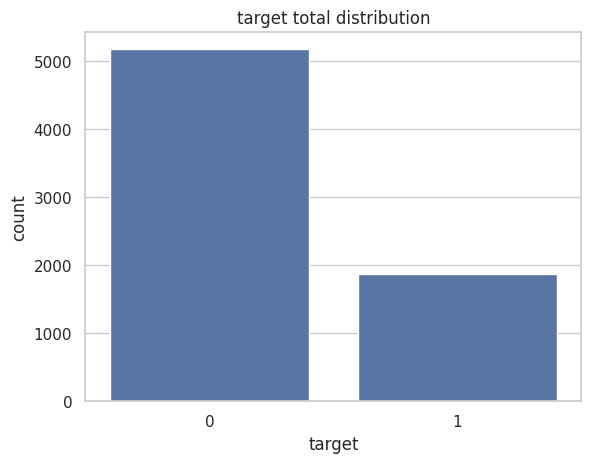

In [8]:
# директория для сохранения картинок
ASSETS_DIR = "assets"

# установка названия колонки для агрегации
x = "target"

# подсчёт количества каждого уникального значения в колонке и сброс индекса для последующей визуализации
target_agg = df[x].value_counts().reset_index()

# создание столбчатой диаграммы для визуализации распределения целевой переменной
sns.barplot(
    target_agg,
    x=x,
    y='count'
)

# установка заголовка графика
plt.title(f"{x} total distribution")

# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, "target_count"))

## Задача №6

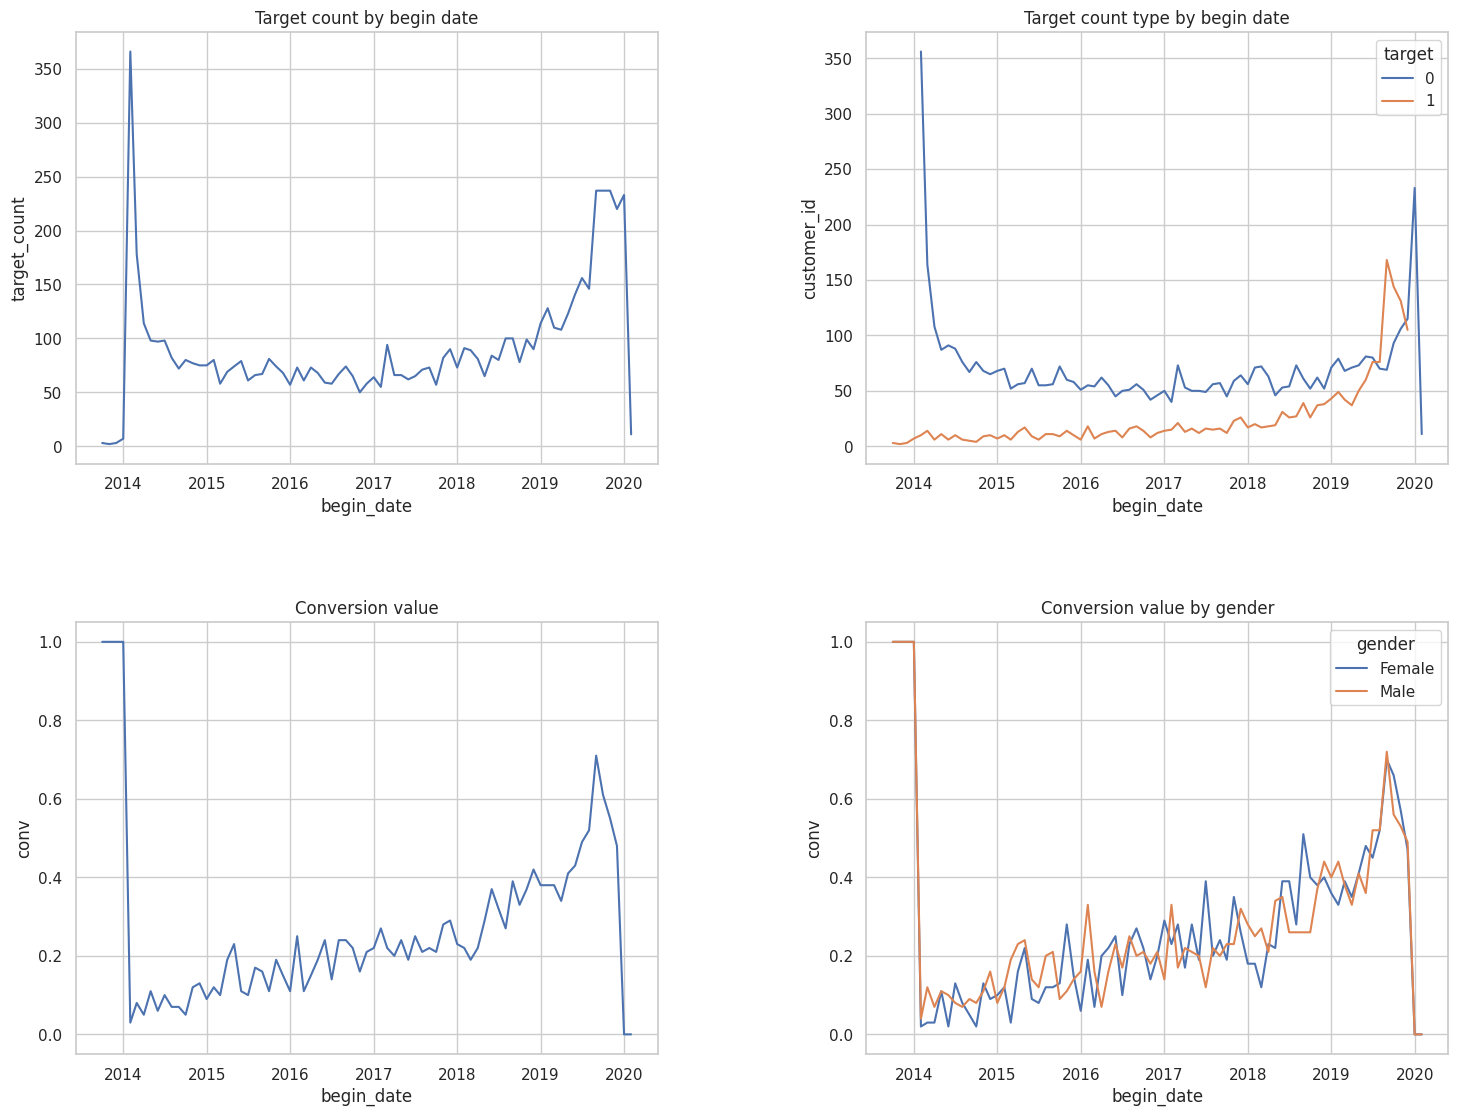

In [9]:
# установка переменных для анализа
x = "begin_date"
target = "target"

# определение статистики для агрегации
stat = ["count"]

# агрегация количества целей по датам начала с последующим сбросом индекса
target_agg_by_date = df[[x, target]].groupby([x]).agg(stat).reset_index()
# удаление мультиуровневости заголовков после агрегации и переименование для удобства
target_agg_by_date.columns = target_agg_by_date.columns.droplevel()
target_agg_by_date.columns = [x, "target_count"]

# подсчёт количества клиентов для каждого значения цели по датам
target_agg = df[[x, target, "customer_id"]].groupby([x, target]).count().reset_index()

# расчёт суммы и количества для конверсии по датам
conversion_agg = df[[x, target]].groupby([x])["target"].agg(["sum", "count"]).reset_index()
# вычисление коэффициента конверсии и округление до двух знаков
conversion_agg["conv"] = (conversion_agg["sum"]/conversion_agg["count"]).round(2)

# аналогичный расчёт конверсии, но с дополнительным разделением по полу
conversion_agg_gender = df[[x, target, "gender"]].groupby([x, "gender"])[target].agg(["sum", "count"]).reset_index()
conversion_agg_gender["conv"] = (conversion_agg_gender["sum"]/conversion_agg_gender["count"]).round(2)

# инициализация фигуры для отображения нескольких графиков
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.6)  # настройка отступов между подграфиками
fig.set_size_inches(16.5, 12.5, forward=True)  # установка размера фигуры

# визуализация общего количества целей по датам начала
sns.lineplot(data=target_agg_by_date, x=x, y="target_count", ax=axs[0, 0])
axs[0, 0].set_title("Target count by begin date")

# визуализация количества клиентов для каждого типа цели по датам
sns.lineplot(data=target_agg, x=x, y="customer_id", hue=target, ax=axs[0, 1])
axs[0, 1].set_title("Target count type by begin date")

# визуализация коэффициента конверсии по датам
sns.lineplot(data=conversion_agg, x=x, y="conv", ax=axs[1, 0])
axs[1, 0].set_title("Conversion value")

# визуализация коэффициента конверсии по датам с разделением по полу
sns.lineplot(data=conversion_agg_gender, x=x, y="conv", hue="gender", ax=axs[1, 1])
axs[1, 1].set_title("Conversion value by gender")

# сохранение визуализации в файл
plt.savefig(os.path.join(ASSETS_DIR, "target_by_date"))

## Задача №7

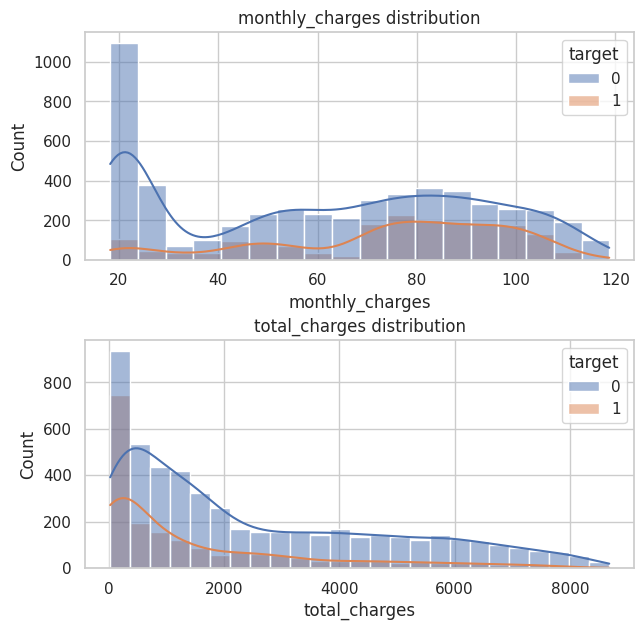

In [10]:
# определение списка столбцов с данными о платежах и целевой переменной
charges = ["monthly_charges", "total_charges"]
target = "target"

# инициализация фигуры для отображения гистограмм
fig, axs = plt.subplots(2, 1)
fig.tight_layout(pad=1.5)  # настройка отступов между подграфиками
fig.set_size_inches(6.5, 6.5, forward=True)  # установка размера фигуры

# визуализация распределения ежемесячных платежей с разделением по целевой переменной
sns.histplot(
    data=df, # датафрейм с данными
    x=charges[0], # первый вид платежей для визуализации
    hue=target, # разделение данных по целевой переменной
    kde=True, # включение оценки плотности распределения (Kernel Density Estimate)
    ax=axs[0] # указание, на каком подграфике отобразить гистограмму
)
axs[0].set_title(f"{charges[0]} distribution")  # установка заголовка для гистограммы

# визуализация распределения общих платежей с разделением по целевой переменной
sns.histplot(
    data=df, # датафрейм с данными
    x=charges[1], # первый вид платежей для визуализации
    hue=target, # разделение данных по целевой переменной
    kde=True, # включение оценки плотности распределения (Kernel Density Estimate)
    ax=axs[1] # указание, на каком подграфике отобразить гистограмму
)
axs[1].set_title(f"{charges[1]} distribution")  # Установка заголовка для второй гистограммы

# сохранение фигуры с гистограммами в файл
plt.savefig(os.path.join(ASSETS_DIR, "chargest_by_target_dist"))

## Задача №8

In [11]:
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_artifacts(ASSETS_DIR)